## Download the dataset

In [1]:
import os
import requests
import warnings
warnings.filterwarnings("ignore")

FILE_URL = "TODO" # You can obtain the link for GeneratedLabelledFlows.zip through https://www.unb.ca/cic/datasets/ids-2017.html
SAVE_DIR = './'

# Ensure directory exists
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Start the download process
response = requests.get(FILE_URL, stream=True)
filename = FILE_URL.split('/')[-1]  # Extract the file name from the URL
file_path = os.path.join(SAVE_DIR, filename)  # Correct the file path

print(f"Downloading {filename} ...")

# Check if the request was successful
if response.status_code == 200:
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"{filename} downloaded to {file_path}")  # Print the correct file path after download
else:
    print(f"Failed to download {filename}. Status code: {response.status_code}")  # Include the status code in the error message

/Users/pekaradrian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


GeneratedLabelledFlows.zip downloaded to ./GeneratedLabelledFlows.zip


## Unzip the dataset

In [5]:
import zipfile

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(SAVE_DIR)
print(f"{filename} has been unzipped into {SAVE_DIR}")

GeneratedLabelledFlows.zip has been unzipped into ./


## Tidy up the folder structure, fix column names, merge separate CSVs

In [6]:
!mv TrafficLabelling\ / datasets
!mv datasets/Wednesday-workingHours.pcap_ISCX.csv datasets/Wednesday-WorkingHours.pcap_ISCX.csv
PATH = "datasets"

In [8]:
%%bash
# Navigate to the CSVs directory
cd datasets

# Loop through each CSV file and remove spaces from the header
for file in *.csv; do
  sed -i '' -e '1s/^[[:space:]]*//;1s/,[[:space:]]*/,/g' "$file" # MacOS
  # sed -i '1s/, /,/g' "$file" # Linux
done

# Navigate back to the original directory
# cd -

In [9]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Read the CSV files
with open(f'{PATH}/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'r', encoding='utf-8', errors='replace') as file:
    df1 = pd.read_csv(file)
    df1["Label"] = df1["Label"].str.replace('�', '-', regex=False)
    
df2 = pd.read_csv(f'{PATH}/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', delimiter=",")

# Merge the dataframes
df = pd.concat([df1, df2])

# Write the merged dataframe to a CSV
df.to_csv(f'{PATH}/Thursday-WorkingHours.pcap_ISCX.csv', index=False)

In [10]:
!rm datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
!rm datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv

In [11]:
import pandas as pd

# Read the CSV files
df1 = pd.read_csv(f'{PATH}/Friday-WorkingHours-Morning.pcap_ISCX.csv', delimiter=",")
df2 = pd.read_csv(f'{PATH}/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', delimiter=",")
df3 = pd.read_csv(f'{PATH}/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', delimiter=",")

# Merge the dataframes
df = pd.concat([df1, df2, df3])

# Write the merged dataframe to a CSV
df.to_csv(f'{PATH}/Friday-WorkingHours.pcap_ISCX.csv', index=False)

In [12]:
!rm datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv
!rm datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
!rm datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

In [13]:
!mv datasets/Monday-WorkingHours.pcap_ISCX.csv datasets/Monday-WorkingHours.csv
!mv datasets/Tuesday-WorkingHours.pcap_ISCX.csv datasets/Tuesday-WorkingHours.csv
!mv datasets/Wednesday-WorkingHours.pcap_ISCX.csv datasets/Wednesday-WorkingHours.csv
!mv datasets/Thursday-WorkingHours.pcap_ISCX.csv datasets/Thursday-WorkingHours.csv
!mv datasets/Friday-WorkingHours.pcap_ISCX.csv datasets/Friday-WorkingHours.csv

## Determine dataset statistics

In [14]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

PATH = "datasets"

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Initializing the table.
header = ["DS", "TOTAL", "BENIGN", "ANOMALY", "NaN", "NaN_ROWS", "NEG_ROWS", "Anomaly breakdown"]
rowh = "{:^10}  "*(len(header)-1) + "{:^40}"
row = "{:^10}  "*(len(header)-1) + "{:<34}" + "{:>6}"
sep = ["-"*10]*(len(header)-1) + ["-"*40]
print(rowh.format(*header))

for day in DAYS:
    print(rowh.format(*sep))

    # CSV
    csv = pd.read_csv(os.path.join(PATH,f"{day}-WorkingHours.csv"))
    csv["Label"].fillna('NaN', inplace=True)

    TOTAL = len(csv)
    BENIGN = len(csv[csv["Label"] == "BENIGN"])
    ANOMALY = len(csv[(csv["Label"] != "BENIGN") & (csv["Label"] != "NaN")])
    NaN = len(csv[csv["Label"] == "NaN"])

    # Calculate NaN rows
    NaN_rows = pd.isnull(csv).any(axis=1).sum()

    # Select only numerical columns for negative values check
    numerical_columns = csv.select_dtypes(include=['int64', 'float64'])

    # Calculate Negative rows in numerical columns
    negative_rows_count = (numerical_columns < 0).any(axis=1).sum()

    print(row.format(day, TOTAL, BENIGN, ANOMALY, NaN, NaN_rows, negative_rows_count, "",""))
    for label in sorted(csv["Label"].unique().tolist()):
        if label == "BENIGN" or label == "NaN":
            continue
        print(row.format("","","","","","","", label, len(csv[csv["Label"] == label])))

    DS        TOTAL       BENIGN     ANOMALY       NaN       NaN_ROWS    NEG_ROWS              Anomaly breakdown            
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------
  Monday      529918      529918        0           0           64        299597                                            
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------
 Tuesday      445909      432074      13835         0          201        257104                                            
                                                                                    FTP-Patator                         7938
                                                                                    SSH-Patator                         5897
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------


## Remove rows with unknown labels

In [15]:
csv_filename = "Thursday-WorkingHours.csv"

# Read the CSV file into a pandas dataframe.
csv = pd.read_csv(os.path.join(PATH, csv_filename))

# Remove all rows where the column 'Label' is NaN.
csv_cleaned = csv.dropna(subset=['Label'])

# Write the cleaned dataframe back to CSV.
csv_cleaned.to_csv(os.path.join(PATH, csv_filename), index=False)

## Show dataset statistics after removal

In [16]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

PATH = "datasets"

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Initializing the table.
header = ["DS", "TOTAL", "BENIGN", "ANOMALY", "NaN", "NaN_ROWS", "NEG_ROWS", "Anomaly breakdown"]
rowh = "{:^10}  "*(len(header)-1) + "{:^40}"
row = "{:^10}  "*(len(header)-1) + "{:<34}" + "{:>6}"
sep = ["-"*10]*(len(header)-1) + ["-"*40]
print(rowh.format(*header))

for day in DAYS:
    print(rowh.format(*sep))

    # CSV
    csv = pd.read_csv(os.path.join(PATH,f"{day}-WorkingHours.csv"))
    csv["Label"].fillna('NaN', inplace=True)

    TOTAL = len(csv)
    BENIGN = len(csv[csv["Label"] == "BENIGN"])
    ANOMALY = len(csv[(csv["Label"] != "BENIGN") & (csv["Label"] != "NaN")])
    NaN = len(csv[csv["Label"] == "NaN"])

    # Calculate NaN rows
    NaN_rows = pd.isnull(csv).any(axis=1).sum()

    # Select only numerical columns for negative values check
    numerical_columns = csv.select_dtypes(include=['int64', 'float64'])

    # Calculate Negative rows in numerical columns
    negative_rows_count = (numerical_columns < 0).any(axis=1).sum()

    print(row.format(day, TOTAL, BENIGN, ANOMALY, NaN, NaN_rows, negative_rows_count, "",""))
    for label in sorted(csv["Label"].unique().tolist()):
        if label == "BENIGN" or label == "NaN":
            continue
        print(row.format("","","","","","","", label, len(csv[csv["Label"] == label])))

    DS        TOTAL       BENIGN     ANOMALY       NaN       NaN_ROWS    NEG_ROWS              Anomaly breakdown            
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------
  Monday      529918      529918        0           0           64        299597                                            
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------
 Tuesday      445909      432074      13835         0          201        257104                                            
                                                                                    FTP-Patator                         7938
                                                                                    SSH-Patator                         5897
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------------------------------------


## Show column names with negative values

In [17]:
import pandas as pd
import os

PATH = "datasets"
DAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for day in DAYS:
    # Read the CSV file
    csv = pd.read_csv(os.path.join(PATH, f"{day}-WorkingHours.csv"))
    csv.dropna(inplace=True)  # Drop any rows with NaN values in any column
    
    # Select only numerical columns for negative values check
    numerical_columns = csv.select_dtypes(include=['int64', 'float64'])
    
    # Create a boolean mask where each cell is True if it's negative
    negative_values_mask = numerical_columns < 0
    
    # Find columns that have at least one negative value
    columns_with_negative = negative_values_mask.any(axis=0)
    
    # Get the names of the columns that have negative values
    negative_column_names = numerical_columns.columns[columns_with_negative]

    # Print the day and the negative column names
    print(day)
    print("Columns with negative values:", list(negative_column_names))
    print("\n")

Monday
Columns with negative values: ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward']


Tuesday
Columns with negative values: ['Flow Duration', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward']


Wednesday
Columns with negative values: ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Min', 'Fwd Header Length', 'Fwd Header Length.1', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward']


Thursday
Columns with negative values: ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Init_Win_bytes_forward', 'Init_

In [20]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

N = 1

# Initializing the table.
header = ["DS", "TOTAL", "BENIGN", "ANOMALY",
          f"T_FIN>{N}", f"B_FIN>{N}", f"A_FIN>{N}",
          f"T_RST>{N}", f"B_RST>{N}", f"A_RST>{N}"]
rowh = "{:^9}  "*(len(header))
row = "{:^9}  "*(len(header))
sep = ["-"*9]*(len(header)) + ["-"*39]
print(rowh.format(*header))

for day in DAYS:
    print(rowh.format(*sep))

    # CSV
    csv = pd.read_csv(os.path.join(PATH,f"{day}-WorkingHours.csv"))
    csv.dropna(inplace=True) # Drop any rows with NaN values in any column
    # csv["Label"].fillna('NaN', inplace=True)

    TOTAL = len(csv)
    FIN_GT = len(csv[csv["FIN Flag Count"] > N])
    RST_GT = len(csv[csv["RST Flag Count"] > N])
    BENIGN = len(csv[csv["Label"] == "BENIGN"])
    BENIGN_FIN_GT = len(csv[(csv["Label"] == "BENIGN") & (csv["FIN Flag Count"] > N)])
    BENIGN_RST_GT = len(csv[(csv["Label"] == "BENIGN") & (csv["RST Flag Count"] > N)])
    ANOMALY = len(csv[(csv["Label"] != "BENIGN")])
    ANOMALY_FIN_GT = len(csv[(csv["Label"] != "BENIGN") & (csv["FIN Flag Count"] > N)])
    ANOMALY_RST_GT = len(csv[(csv["Label"] != "BENIGN") & (csv["RST Flag Count"] > N)])

    print(row.format(day, TOTAL, BENIGN, ANOMALY,
                     FIN_GT, BENIGN_FIN_GT, ANOMALY_FIN_GT,
                     RST_GT, BENIGN_RST_GT, ANOMALY_RST_GT))

   DS        TOTAL     BENIGN     ANOMALY    T_FIN>1    B_FIN>1    A_FIN>1    T_RST>1    B_RST>1    A_RST>1   
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Monday     529854     529854        0          0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
 Tuesday    445708     431873      13835        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Wednesday   691695     439972     251723        0          0          0          0          0          0      
---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  
Thursday    458930     456714      2216         0          0          0          0          0          0      
-

In [21]:
for day in DAYS:
    csv = pd.read_csv(os.path.join(PATH,f"{day}-WorkingHours.csv"))
    csv.dropna(inplace=True) # Drop any rows with NaN values in any column
    print(day)
    print(csv[['FIN Flag Count', 'RST Flag Count']].describe())
    print("\n")

Monday
       FIN Flag Count  RST Flag Count
count   529854.000000   529854.000000
mean         0.022950        0.000136
std          0.149743        0.011656
min          0.000000        0.000000
25%          0.000000        0.000000
50%          0.000000        0.000000
75%          0.000000        0.000000
max          1.000000        1.000000


Tuesday
       FIN Flag Count  RST Flag Count
count   445708.000000   445708.000000
mean         0.018281        0.000337
std          0.133966        0.018342
min          0.000000        0.000000
25%          0.000000        0.000000
50%          0.000000        0.000000
75%          0.000000        0.000000
max          1.000000        1.000000


Wednesday
       FIN Flag Count  RST Flag Count
count   691695.000000   691695.000000
mean         0.097443        0.000338
std          0.296561        0.018390
min          0.000000        0.000000
25%          0.000000        0.000000
50%          0.000000        0.000000
75%          0.000000

In [22]:
import pandas as pd
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# GLOBAL VARIABLES
MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [MONDAY, TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]
N=5

for day in DAYS:
    # Read the CSV file
    csv = pd.read_csv(os.path.join(PATH, f"{day}-WorkingHours.csv"))
    csv.dropna(inplace=True)  # Drop any rows with NaN values in any column

    # # Get descriptive statistics
    print(f"Statistics for {day}:")
    # stats = csv[['FIN Flag Count', 'RST Flag Count']].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 1.0])
    # print(stats)

    # Print the top N value counts for each column without the index name and series description
    fin_counts = csv['FIN Flag Count'].value_counts().head(N).to_string(header=False, index=True)
    rst_counts = csv['RST Flag Count'].value_counts().head(N).to_string(header=False, index=True)
    
    print(f"\nTop {N} Value Counts for FIN Packets:")
    print(fin_counts)
    
    print(f"\nTop {N} Value Counts for RST Packets:")
    print(rst_counts)
    
    print("\n" + "-"*50 + "\n")

Statistics for Monday:

Top 5 Value Counts for FIN Packets:
0    517694
1     12160

Top 5 Value Counts for RST Packets:
0    529782
1        72

--------------------------------------------------

Statistics for Tuesday:

Top 5 Value Counts for FIN Packets:
0    437560
1      8148

Top 5 Value Counts for RST Packets:
0    445558
1       150

--------------------------------------------------

Statistics for Wednesday:

Top 5 Value Counts for FIN Packets:
0    624294
1     67401

Top 5 Value Counts for RST Packets:
0    691461
1       234

--------------------------------------------------

Statistics for Thursday:

Top 5 Value Counts for FIN Packets:
0.0    452103
1.0      6827

Top 5 Value Counts for RST Packets:
0.0    458796
1.0       134

--------------------------------------------------

Statistics for Friday:

Top 5 Value Counts for FIN Packets:
0    697631
1      5567

Top 5 Value Counts for RST Packets:
0    703102
1        96

------------------------------------------------

## Plot Sankey diagrams

Sankey Diagram for datasets/Wednesday-WorkingHours.csv


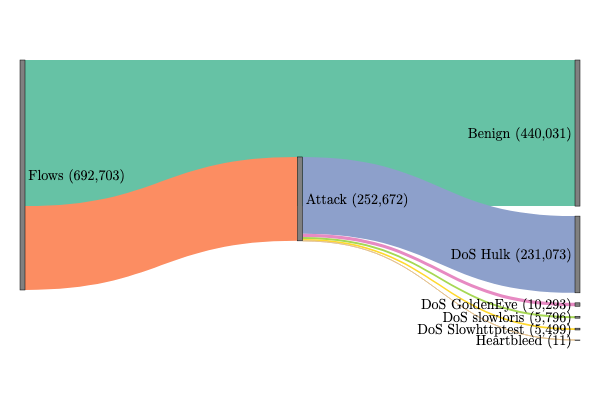

Sankey Diagram for datasets/Friday-WorkingHours.csv


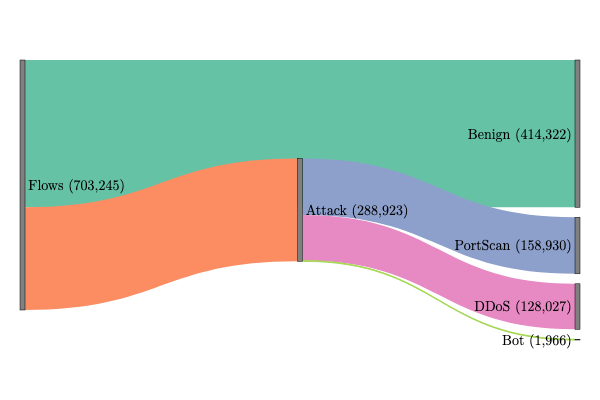

Sankey Diagram for datasets/Monday-WorkingHours.csv


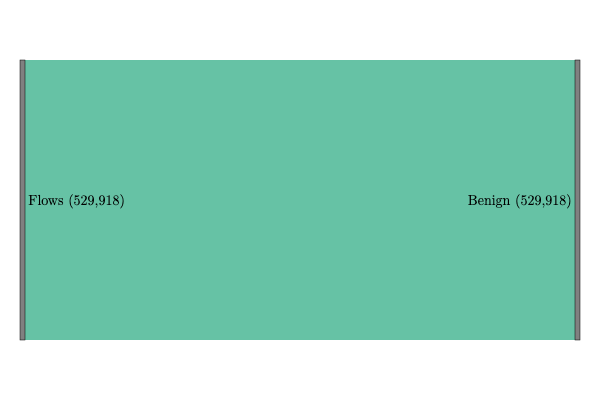

Sankey Diagram for datasets/Tuesday-WorkingHours.csv


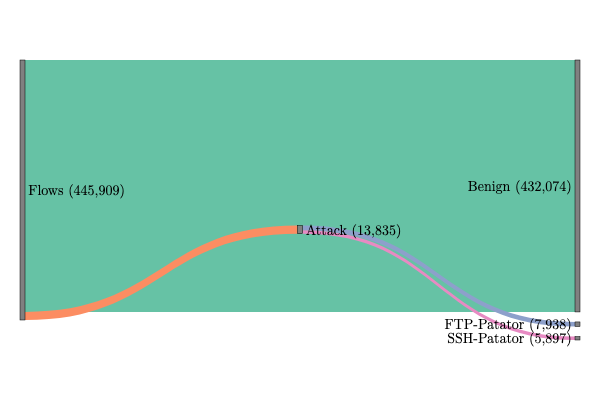

Sankey Diagram for datasets/Thursday-WorkingHours.csv


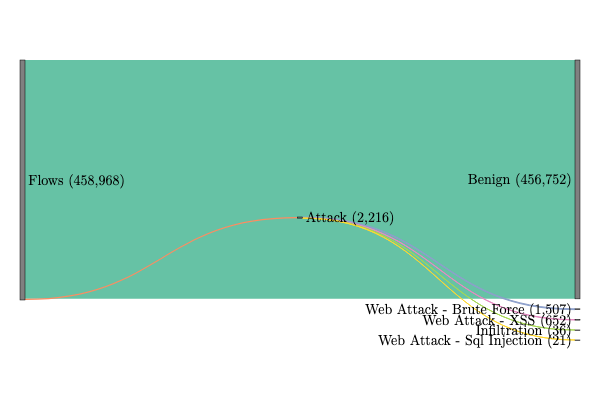

In [23]:
import glob
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import json

# Define the path to the CSV files and the output directory
csv_path = PATH
output_path = PATH + '/data-distribution'

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Find all CSV files in the local directory and sort them in alphabetical order
csv_files = glob.glob(os.path.join(csv_path, '*.csv'))

# Set the color palette
color_palette = px.colors.qualitative.Set2

# Create an empty dictionary to hold the summary data
summary = {}

for csv_file in csv_files:
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Extract the day (filename without prefix and suffix) from the CSV file's name
    day = os.path.basename(csv_file).split('-')[0]

    # Count the total number of rows, benign rows, and attack rows
    total_rows = len(df)
    benign_rows = len(df[df['Label'] == 'BENIGN'])
    attack_rows = len(df[df['Label'].notna() & (df['Label'] != 'BENIGN')])
    nan_rows = total_rows - benign_rows - attack_rows  # NaN rows are the remainder

    if nan_rows > 0:
        # Find the unique attack types and their counts, excluding NaN labels
        attack_types = df[df['Label'].notna() & (df['Label'] != 'BENIGN')]['Label'].value_counts()

        # Define the nodes of the Sankey diagram including NaN flows
        nodes = [
            dict(label=f'Flows ({total_rows:,})'),
            dict(label=f'Benign ({benign_rows:,})'),
            dict(label=f'Attack ({attack_rows:,})'),
            dict(label=f'Unknown ({nan_rows:,})')  # Node for NaN flows
        ]
        nodes.extend(dict(label=f'{attack_type} ({count:,})') for attack_type, count in attack_types.items())

        # Create a hierarchy for the current day and add it to the main dictionary including NaN flows
        summary[day] = {
            "Total Flows": total_rows,
            "Benign": benign_rows,
            "Attack": {
                "Total Attack Flows": attack_rows,
                "Attack Types": attack_types.to_dict()
            },
            "Unknown": nan_rows  # Summary for NaN flows
        }

        # Define the links of the Sankey diagram including NaN flows
        links = [
            dict(source=0, target=1, value=benign_rows, color=color_palette[0]),
            dict(source=0, target=2, value=attack_rows, color=color_palette[1]),
            dict(source=0, target=3, value=nan_rows, color=color_palette[2]),  # Link for NaN flows
        ]
        offset = len(nodes) - len(attack_types) - 1  # Calculate the offset index for attack type nodes
        links.extend(dict(source=2, target=i + offset, value=count, color=color_palette[(i+3) % len(color_palette)])
                     for i, count in enumerate(attack_types))
    
    else:

        # Find the unique attack types and their counts
        attack_types = df[df['Label'] != 'BENIGN']['Label'].value_counts()

        # Define the nodes of the Sankey diagram
        nodes = [
            dict(label=f'Flows ({total_rows:,})'),  # Include thousands separator
            dict(label=f'Benign ({benign_rows:,})'),  # Include thousands separator
            dict(label=f'Attack ({attack_rows:,})'),  # Include thousands separator
        ]
        nodes.extend(dict(label=f'{attack_type} ({count:,})') for attack_type, count in
                     attack_types.items())  # Include thousands separator

        # Create a hierarchy for the current day and add it to the main dictionary
        summary[day] = {
            "Total Flows": total_rows,
            "Benign": benign_rows,
            "Attack": {
                "Total Attack Flows": attack_rows,
                "Attack Types": attack_types.to_dict()  # Convert Series to dictionary
            }
        }

        # Define the links of the Sankey diagram
        links = [
            dict(source=0, target=1, value=benign_rows, color=color_palette[0]),
            dict(source=0, target=2, value=attack_rows, color=color_palette[1]),
        ]
        links.extend(dict(source=2, target=i+3, value=count, color=color_palette[(i+2)%len(color_palette)]) for i, count in enumerate(attack_types))

    # Create the Sankey diagram figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=10,  # Reduce padding between nodes
            thickness=5,  # Reduce node thickness
            line=dict(color='black', width=0.5),
            label=[node['label'] for node in nodes],
            color='gray'  # Change node color for better print readability
        ),
        link=dict(
            source=[link['source'] for link in links],
            target=[link['target'] for link in links],
            value=[link['value'] for link in links],
            color=[link['color'] for link in links]  # Set link color
        )
    )])

    print(f'Sankey Diagram for {csv_file}')
    
    # Customize the layout of the Sankey diagram
    fig.update_layout(
#         title_text=f'Sankey Diagram for {csv_file}',
        font=dict(
            family='CMU Serif',
            size=14,  # Reduce font size
            color='black'  # Change font color to black for better print readability
        ),
        autosize=True,  # Make the layout tight
        width=600,  # Reduce figure width
        height=400,  # Reduce figure height
        # paper_bgcolor='white',  # Change background color to white for better print readability
        paper_bgcolor='rgba(0,0,0,0)',  # Set paper background to transparent
        # plot_bgcolor='white'  # Change plot background color to white for better print readability
        plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
        margin = dict(l=20, r=20, t=60, b=60)  # Reduce margins
    )

    # Show the plot
    # pyo.iplot(fig)

    # Show the plot as a static image
    img_bytes = pio.to_image(fig, format='png')
    from IPython.display import Image, display
    display(Image(img_bytes))
    
    # Save the Sankey diagram as a PNG file
    pio.write_image(fig, os.path.join(output_path, f"{day}_sankey.png"), scale=5)

with open(os.path.join(output_path, "summary.json"), "w") as outfile:
    json.dump(summary, outfile, indent=4)